# Informações dos dados obtidos.

O conjunto de dados contém 9358 resultados médios de 5 sensores químicos de um dispositivo multisensor (PTXX.SX). O dispositivo estava localizado a nível da rua, dentro de uma cidade significativamente poluída. Os dados foram registrados de março de 2004 a fevereiro de 2005 (um ano). Valores ausentes são marcados com o valor -200. A medida de outros sensores também está disponível e algumas podem ser redundantes. ***A variável chave a ser analisada é PT08.S1 (CO), concentração de CO na atmosfera.***
Informação das colunas:

1.  Date (DD/MM/YYYY)
2.  Time (HH.MM.SS)
3.  PT08.S1 (CO) – Variável de predição
4.  Non Metanic HydroCarbons Concentration (mg/m^3)
5.  Benzene Concentration (mg/m^3)
6.  PT08.S2 (NMHC)
7.  NOx Concentration (ppb)
8.  PT08.S3 (NOx)
9.  NO2 Concentration (mg/m^3)
10. PT08.S4 (NO2s)
11. PT08.S5 (O3)
12. Temperature (C)
13. Relative Humidity (%)
14. AH Absolute Humidity
15. Dia da Semana	
16. Mês
17. Estações
18. Target_log
19. Target_log_dff_1
20. Target_log_dff_2
21. Target_log_dff_3  


# Objetivo.
 
A primeira parte foi encarregada de tratar os dados disponibilizados e a segunda parte está encarregada de analisá-los. Agora será testado a melhor maneira de codificar as variáveis categóricas e aplicação de algumas transformações nos dados. Para fazer isso será adotado uma metodologia que será descrita a seguir.
 
* Lembrando que o objetivo principal é de prever a concentração de carbono a uma hora no futuro.
 
* **Observação esse algoritmo não está projetado para previsão de um horizonte de mais de uma hora**.

# Metodologia.
### Parte 1.
 
* Na parte 1 será encarregada de testar a codificação que apresenta o melhor resultado para o modelo.
 
* Será escolhido um modelo de machine learning como base, no caso será floresta aleatória. Ele foi escolhido pela sua dificuldade em sobreajustar aos dados.
 
* Depois disso todas as variáveis categóricas passaram por transformações:
 * Banco de dados 1: Estações -> Labelenconder, Dias da semana - > Labelencoder.
 * Banco de dados 2: Estações -> get_dummies, Dias da semana - > Labelencoder.
 * Banco de dados 3: Estações -> Labelencoder, Dias da semana - > get_dummies.
 * Banco de dados 4: Estações -> get_dummies, Dias da semana - > get_dummies.
 
 
* Após ele passa por essas transformações o modelo de arvore aleatória será avaliado pela validação cruzada (**respeitando a dependência temporal dos dados**) e será avaliado por essa métrica:
 
 * MAPE -> O erro absoluto percentual médio (MAPE) é um dos mais usados na Estatística por ser de fácil compreensão. Esta medida expressa a porcentagem média dos erros (em valor absoluto) cometidos na previsão de um regressão; quanto menor esta medida, melhor será a previsão. Referêência https://www.ufjf.br/cursoestatistica/files/2015/05/Compara%C3%A7%C3%A3o-de-diferentes-m%C3%A9todos-de-previs%C3%A3o-em-s%C3%A9ries-temporais-com-valores-discrepantes.pdf
 
### Parte 2.
 
* Foi visto que algumas variáveis apresentam algum comportamento quadrático ou logaritmo em relação aos dados de Target. Logo uma transformação básica nesses dados pode fazer com que a relação entre elas e o Target seja mais próxima do linear e diminua a variância deles. Sendo assim será aplicado algumas transformações nos dados para ver se o desempenho do modelo de regressão base será melhorado.
 
### Extra
* Neste trabalho também será visto se a presença de outliner prejudica o desempenho do modelo base.
 
 



# Funções.

In [ ]:
def sep_dados(d,col):
  X_teste = d[d['Date'] > '2004-12-01']
  X_train = d[d['Date'] <= '2004-12-01']

  Y_teste = d[col][d['Date'] > '2004-12-01']
  Y_train = d[col][d['Date'] <= '2004-12-01']
  
  X_train = X_train.drop(columns = ['Date','Target_log'])
  X_teste = X_teste.drop(columns = ['Date','Target_log'])

  Y_train = Y_train.drop(columns = 'Date')
  Y_teste = Y_teste.drop(columns = 'Date')

  return X_train,X_teste,Y_train,Y_teste

def label_encoder(d,col):
  enc      = LabelEncoder()
  enc      = enc.fit(df1[col])
  inteiros = enc.fit_transform(d[col])
  d[col]   = inteiros
  return d

def dummies_var(dados,coluna):
  df_aux = dados
  df_aux = df_aux.join(pd.get_dummies(df_aux[coluna], prefix=coluna))
  df_aux = df_aux.drop(columns=coluna)

  return df_aux

def MAPE(y_pred,Y_teste):
  return np.mean(100*np.abs(y_pred - Y_teste)/np.abs(Y_teste))

def cat_TargetEncoder(X_train,X_teste,Y_train,col,flag):

  if flag == 1:
    for i in range(len(col)):
      tenc = TargetEncoder()
      X_train[col[i]] = tenc.fit_transform(X_train[col[i]], Y_train)
      X_teste[col[i]] = tenc.transform(X_teste[col[i]])

  if flag == 0:
      tenc = TargetEncoder()
      X_train[col] = tenc.fit_transform(X_train[col], Y_train)
      X_teste[col] = tenc.transform(X_teste[col])

  return X_train,X_teste

def modelo(model,X_train,Y_train,X_teste,Y_teste):
  # treinado e avaliando o modelo
  md       = model.fit(X_train, Y_train)
  y_pred   = md.predict(X_teste)
  y_pred   = 10**y_pred
  Y_teste  = 10**Y_teste
  resultado = MAPE(y_pred,Y_teste)
  bias      = np.mean(y_pred-Y_teste)
  erro      = np.abs(y_pred-Y_teste)
  return resultado,bias,erro

def winsorize(Y_train,corte1,corte2):
  winsor_lower = np.percentile(Y_train, corte1) 
  winsor_upper = np.percentile(Y_train, corte2)
  Y_train_n   = Y_train1.clip(lower=winsor_lower, upper=winsor_upper)
  return Y_train_n


def MAPE(y_pred,Y_teste):
  return np.mean(100*np.abs(y_pred - Y_teste)/np.abs(Y_teste))


def validation(X,Y,Date):
  Ypred = []
  Yv    = []
  tscv = TimeSeriesSplit(n_splits=10)
  vetor_MAPE = np.zeros(10) 
  i = 0
  for linhas_treino, linhas_valid in tscv.split(X):    
    X_t, X_v = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_t, y_v = Y[linhas_treino], Y[linhas_valid]

    md                    = model.fit(X_t, y_t)
    y_pred                = md.predict(X_v)

    y_pred = 10**y_pred
    y_v    = 10**y_v
    Ypred.append(y_pred)
    Yv.append(y_v)

    mape = MAPE(y_pred,y_v)
    vetor_MAPE[i] = mape
    i = i + 1
    print('Data:',Date[linhas_valid[0]],'-',Date[linhas_valid[-1]], '->', 'MAPE:',np.format_float_positional(mape,5))

  print("\n")
  print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE),5),'Std:',np.format_float_positional(np.std(vetor_MAPE),5),'Erro:',np.format_float_positional(np.std(vetor_MAPE)/np.sqrt(10),5))

  return Ypred,Yv,vetor_MAPE

# Bibliotecas

In [ ]:
# import pandas as pd
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import statsmodels.tsa.stattools
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_style("whitegrid")
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import wilcoxon
from sklearn.linear_model import LinearRegression

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importado os dados

In [ ]:
df = pd.read_csv('/content/drive/My Drive/new_dados2.csv',encoding = "UTF-8")

In [ ]:
df.head() # visualizando os dados.

,Unnamed: 0,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Dia da Semana,Mês,Estações,Target_log,Target_log_dff_1,Target_log_dff_2,Target_log_dff_3
0,0,2004-03-10,18,1360,11.9,1046,166.0,1056,113.0,1692,1268,13.6,48.9,0.7578,2,3,Primavera,3.133539,NaN,NaN,NaN
1,1,2004-03-10,19,1292,9.4,955,103.0,1174,92.0,1559,972,13.3,47.7,0.7255,2,3,Primavera,3.111263,3.133539,NaN,NaN
2,2,2004-03-10,20,1402,9.0,939,131.0,1140,114.0,1555,1074,11.9,54.0,0.7502,2,3,Primavera,3.146748,3.111263,3.133539,NaN
3,3,2004-03-10,21,1376,9.2,948,172.0,1092,122.0,1584,1203,11.0,60.0,0.7867,2,3,Primavera,3.138618,3.146748,3.111263,3.133539
4,4,2004-03-10,22,1272,6.5,836,131.0,1205,116.0,1490,1110,11.2,59.6,0.7888,2,3,Primavera,3.104487,3.138618,3.146748,3.111263


In [ ]:
df =df.drop(columns = ['Unnamed: 0','PT08.S1(CO)']) # Excluido colunas que não estão adicionado informações redundate.

* Antes de realizar qualquer análise os dados serão deslocados para provocar o efeito da previsão temporal nos dados.

In [ ]:
ind = ['PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)','NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

In [ ]:
for i in range(len(ind)):
  df[ind[i]] = df[ind[i]].shift(-1)

In [ ]:
df=df.dropna()

# Parte 1

* Será criado cópias dos datasets para poder trabalhar qual é o melhor maneira de modelar o banco de dados.

In [ ]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df4 = df.copy()

### Criando os datasets

* Banco de dados 1.
 * Estações -> Labelenconder
 * Dias da semana - > Labelencoder.
 



In [ ]:
df1                                 = label_encoder(df1,'Estações')

In [ ]:
df1.index = np.arange(df1.shape[0])
X1 = df1.drop(columns = ['Target_log','Date'])
Y1 = df1['Target_log']

In [ ]:
df1.head(1)


,Date,Time,C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Dia da Semana,Mês,Estações,Target_log,Target_log_dff_1,Target_log_dff_2,Target_log_dff_3
0,2004-03-10,21,9.2,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2,3,2,3.138618,3.146748,3.111263,3.133539


* Banco de dados 2.
 * Estações -> get_dummies.
 * Dias da semana - > Labelencoder.
 



In [ ]:
df2 = dummies_var(df2,'Estações')

In [ ]:
df2.head(1)

,Date,Time,C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Dia da Semana,Mês,Target_log,Target_log_dff_1,Target_log_dff_2,Target_log_dff_3,Estações_Inverno,Estações_Outono,Estações_Primavera,Estações_Verão
3,2004-03-10,21,9.2,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2,3,3.138618,3.146748,3.111263,3.133539,0,0,1,0


In [ ]:
df2.index = np.arange(df2.shape[0])
X2 = df2.drop(columns = ['Target_log','Date'])
Y2 = df2['Target_log']

* Banco de dados 3.
 * Estações -> Labelencoder.
 * Dias da semana - > get_dummies.
 



In [ ]:
df3                                 = dummies_var(df3,'Dia da Semana')
df3                                 = label_encoder(df3,'Estações')

In [ ]:
df3.head(1)

,Date,Time,C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Mês,Estações,Target_log,Target_log_dff_1,Target_log_dff_2,Target_log_dff_3,Dia da Semana_0,Dia da Semana_1,Dia da Semana_2,Dia da Semana_3,Dia da Semana_4,Dia da Semana_5,Dia da Semana_6
3,2004-03-10,21,9.2,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,2,3.138618,3.146748,3.111263,3.133539,0,0,1,0,0,0,0


In [ ]:
df3.index = np.arange(df3.shape[0])
X3 = df3.drop(columns = ['Target_log','Date'])
Y3 = df3['Target_log']

* Banco de dados 4.
 * Estações -> get_dummies.
 * Dias da semana - > get_dummies.



In [ ]:
df4                                 = dummies_var(df4,'Dia da Semana')
df4                                 = dummies_var(df4,'Estações')

In [ ]:
df4.head()

,Date,Time,C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Mês,Target_log,Target_log_dff_1,Target_log_dff_2,Target_log_dff_3,Dia da Semana_0,Dia da Semana_1,Dia da Semana_2,Dia da Semana_3,Dia da Semana_4,Dia da Semana_5,Dia da Semana_6,Estações_Inverno,Estações_Outono,Estações_Primavera,Estações_Verão
3,2004-03-10,21,9.2,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,3.138618,3.146748,3.111263,3.133539,0,0,1,0,0,0,0,0,0,1,0
4,2004-03-10,22,6.5,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,3,3.104487,3.138618,3.146748,3.111263,0,0,1,0,0,0,0,0,0,1,0
5,2004-03-10,23,4.7,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,3,3.078094,3.104487,3.138618,3.146748,0,0,1,0,0,0,0,0,0,1,0
6,2004-03-11,0,3.6,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,3,3.073718,3.078094,3.104487,3.138618,0,0,0,1,0,0,0,0,0,1,0
7,2004-03-11,1,3.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,3,3.055378,3.073718,3.078094,3.104487,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
df4.index = np.arange(df4.shape[0])
X4 = df4.drop(columns = ['Target_log','Date'])
Y4 = df4['Target_log']

### Desempenho das configurações.

In [ ]:
model    = RandomForestRegressor(n_estimators = 100,random_state = 10) # modelo padrão

In [ ]:
Date = df['Date']

In [ ]:
Ypred1,Yv1,vetor_MAPE1 = validation(X1,Y1,Date)

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.26322
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.58207
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.47257
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.74236
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.51789
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74869
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.26308
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.26256
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.03031
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.11860


Mape Geral: 4.40013 Std: 1.82800 Erro: 0.57807


In [ ]:
Ypred2,Yv2,vetor_MAPE2 = validation(X2,Y2,Date)

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.21547
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.55036
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46375
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.72592
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52567
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74507
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23708
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18762
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07946
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.10039


Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


In [ ]:
Ypred3,Yv3,vetor_MAPE3 = validation(X3,Y3,Date)

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.33606
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.69746
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46403
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.71084
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.53210
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.80001
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.29678
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.30843
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.10314
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.15909


Mape Geral: 4.44079 Std: 1.8556 Erro: 0.58679


In [ ]:
Ypred4,Yv4,vetor_MAPE4 = validation(X4,Y4,Date)

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.34319
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.65964
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46307
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.71225
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.54167
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.78239
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.30561
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.22094
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.12710
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.12090


Mape Geral: 4.42768 Std: 1.85225 Erro: 0.58573


In [ ]:
print('Bando de dados 1')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE1),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE1),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE1)/np.sqrt(10),5))
print('\n')
print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Bando de dados 3')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE3),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE3),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE3)/np.sqrt(10),5))
print('\n')
print('Bando de dados 4')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE4),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE4),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE4)/np.sqrt(10),5))


Bando de dados 1
Mape Geral: 4.40013 Std: 1.82800 Erro: 0.57807


Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Bando de dados 3
Mape Geral: 4.44079 Std: 1.8556 Erro: 0.58679


Bando de dados 4
Mape Geral: 4.42768 Std: 1.85225 Erro: 0.58573


* Os erros estão muito próximos e todos estão muito baixos.
* Para verificar se a diferença entre os MAPES foi causada por alguma flutuação estatística será aplicado o teste de hipótese de Wilcoxon.
 
Referência:
 
https://pt.wikipedia.org/wiki/Teste_de_Wilcoxon.
          

* Para aplicar o teste será escolhido o modelo de menor bias e comparado se a sua média é menor do que as de mais.
 
* O p-value reportado por esta função (wilcoxon) é relativo a um teste de duas caudas, ou seja, testa se as médias são diferentes. No nosso caso, estamos mais interessados em saber se uma média é menor do que a outra, ou seja, um teste de uma cauda. A forma mais fácil de converter este número para o que nós desejamos é dividi-lo por 2.
 
* O p-value utilizado é  0,01. No caso daqueles que tiverem abaixo desse valor a probabilidade da diferença de performance entre os modelos ser apenas por sorte é mínima. Podendo rejeitar a hipótese que eles oferecem o mesmo desempenho.
 
Referência:
 
https://www.mariofilho.com/como-criar-um-modelo-simples-para-prever-series-temporais-usando-machine-learning-em-python/#como-criar-um-modelo-simples-para-prever-series-temporais-usando-machine-learning-em-python


In [ ]:
erro1= np.abs(np.concatenate(Ypred1) - np.concatenate(Yv1))
erro2= np.abs(np.concatenate(Ypred2) - np.concatenate(Yv2))
erro3= np.abs(np.concatenate(Ypred3) - np.concatenate(Yv3))
erro4= np.abs(np.concatenate(Ypred4) - np.concatenate(Yv4))

In [ ]:
print('Banco 2 e 1 -> P-value:', np.format_float_positional(np.mean(wilcoxon(erro2,erro1)[1]/2),3))
print('Banco 2 e 3 -> P-value:', np.format_float_positional(np.mean(wilcoxon(erro2,erro3)[1]/2),3))
print('Banco 2 e 4 -> P-value:', np.format_float_positional(np.mean(wilcoxon(erro2,erro4)[1]/2),3))


Banco 2 e 1 -> P-value: 0.000
Banco 2 e 3 -> P-value: 0.000
Banco 2 e 4 -> P-value: 0.000


* Pelos resultados mostrados todos os banco de dados passou p-value por esse motivo será escolhido o de menor MAPE geral e no último intervalo de tempo avaliado.
 
 
* No caso, o banco de dados escolhido é o 2.


#Parte 2
 
* Será aplicado a transformação em uma variável e será visto como o modelo está performando.


In [ ]:
df2_1  = df2.copy()
df2_2  = df2.copy()
df2_3  = df2.copy()
df2_4  = df2.copy()
df2_5  = df2.copy()
df2_9  = df2.copy()
df2_10 = df2.copy()

In [ ]:
columns = ['C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
            'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)','T','RH', 'AH']

###C6H6(GT)

In [ ]:
i=0
print('Normal:',np.format_float_positional(np.corrcoef(df2_1[columns[i]],df2_1['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2_1[columns[i]]),df2_1['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2_1[columns[i]]),df2_1['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2_1[columns[i]]),df2_1['Target_log'])[0][1],3))

Normal: 0.866
SQRT  : 0.893
log   : 0.014
exp   : 0.014


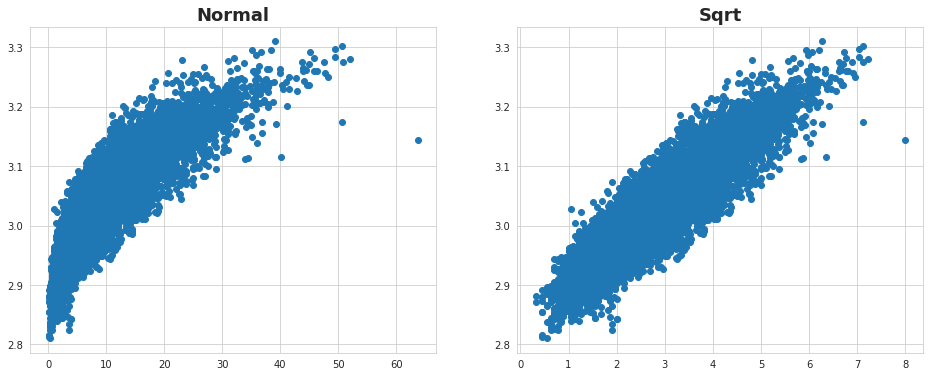

In [ ]:
i = 0
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Normal',size=18,fontweight= 'bold')
plt.plot(df2[columns[i]],df2['Target_log'],'o')
plt.subplot(1,2,2)
plt.title('Sqrt',size=18,fontweight= 'bold')
plt.plot(np.sqrt(df2_1[columns[i]]),df2_1['Target_log'],'o')


In [ ]:
df2_1[columns[i]] = np.sqrt(df2_1[columns[i]])

In [ ]:
df2_1.index = np.arange(df2_1.shape[0])
X21 = df2_1.drop(columns = ['Target_log','Date'])
Y21 = df2_1['Target_log']

In [ ]:
Ypred21,Yv21,vetor_MAPE21 = validation(X21,Y21,Date)

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.24636
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.561
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46698
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.7223
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52824
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.75094
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23408
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18996
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07793
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.09866


Mape Geral: 4.38765 Std: 1.82111 Erro: 0.57588


In [ ]:
print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Tranformação')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE21),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE21),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE21)/np.sqrt(10),5))

Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Tranformação
Mape Geral: 4.38765 Std: 1.82111 Erro: 0.57588


### PT08.S2(NMHC)

In [ ]:
i =1
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.78
SQRT  : 0.785
log   : 0.779
exp   : 0.778


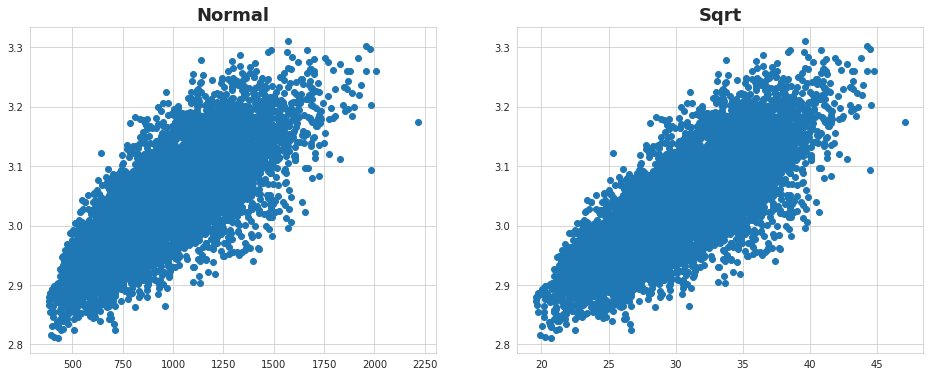

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Normal',size=18,fontweight= 'bold')
plt.plot(df2[columns[i]],df2['Target_log'],'o')
plt.subplot(1,2,2)
plt.title('Sqrt',size=18,fontweight= 'bold')
plt.plot(np.sqrt(df2[columns[i]]),df2['Target_log'],'o')


In [ ]:
df2_2[columns[i]] = np.sqrt(df2_2[columns[i]])

In [ ]:
df2_2.index = np.arange(df2_2.shape[0])
X22 = df2_2.drop(columns = ['Target_log','Date'])
Y22 = df2_2['Target_log']
Ypred22,Yv22,vetor_MAPE22 = validation(X22,Y22,Date)


print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Tranformação')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE22),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE22),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE22)/np.sqrt(10),5))

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.21489
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.55123
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46318
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.72552
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52447
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74503
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23641
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18617
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.0787
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.1009


Mape Geral: 4.38265 Std: 1.81283 Erro: 0.57327
Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Tranformação
Mape Geral: 4.38265 Std: 1.81283 Erro: 0.57327


###PT08.S3(NOx)

In [ ]:
i =2
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.605
SQRT  : 0.635
log   : 0.605
exp   : 0.603


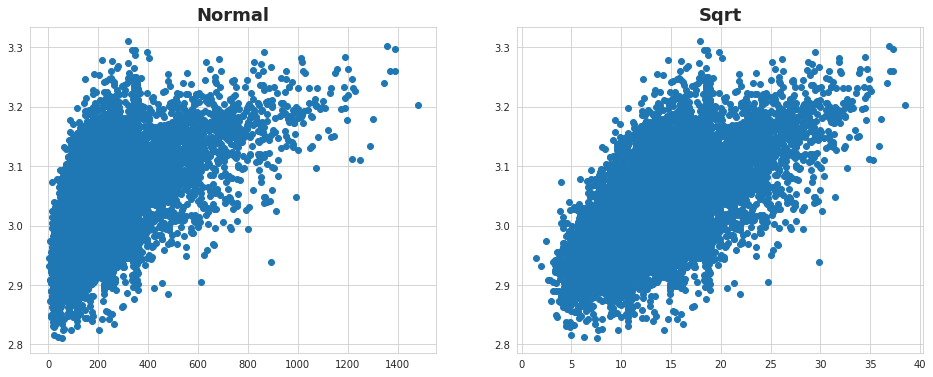

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Normal',size=18,fontweight= 'bold')
plt.plot(df2[columns[i]],df2['Target_log'],'o')
plt.subplot(1,2,2)
plt.title('Sqrt',size=18,fontweight= 'bold')
plt.plot(np.sqrt(df2[columns[i]]),df2['Target_log'],'o')


In [ ]:
df2_3[columns[i]] = np.sqrt(df2_3[columns[i]])

df2_3.index = np.arange(df2_3.shape[0])
X23 = df2_3.drop(columns = ['Target_log','Date'])
Y23 = df2_3['Target_log']
Ypred23,Yv23,vetor_MAPE23 = validation(X23,Y23,Date)


print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Tranformação')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE23),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE23),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE23)/np.sqrt(10),5))

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.21626
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.5518
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46294
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.72635
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52573
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74583
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23696
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18833
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07869
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.10085


Mape Geral: 4.38337 Std: 1.81305 Erro: 0.57334
Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Tranformação
Mape Geral: 4.38337 Std: 1.81305 Erro: 0.57334


###PT08.S3(NOx)

In [ ]:
i = 3
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: -0.726
SQRT  : -0.75
log   : -0.725
exp   : -0.72


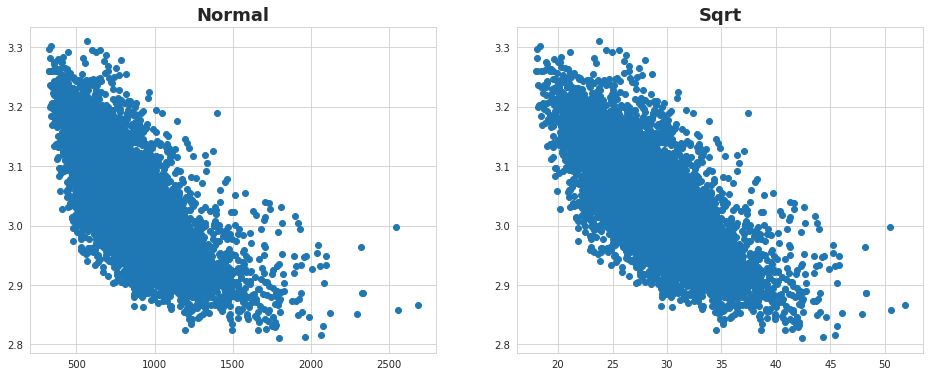

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Normal',size=18,fontweight= 'bold')
plt.plot(df2[columns[i]],df2['Target_log'],'o')
plt.subplot(1,2,2)
plt.title('Sqrt',size=18,fontweight= 'bold')
plt.plot(np.sqrt(df2[columns[i]]),df2['Target_log'],'o')


In [ ]:
df2_4[columns[i]] = np.sqrt(df2_4[columns[i]])

df2_4.index = np.arange(df2_4.shape[0])
X24 = df2_4.drop(columns = ['Target_log','Date'])
Y24 = df2_4['Target_log']
Ypred24,Yv24,vetor_MAPE24 = validation(X23,Y23,Date)


print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Tranformação')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE24),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE24),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE24)/np.sqrt(10),5))

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.21626
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.5518
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46294
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.72635
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52573
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74583
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23696
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18833
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07869
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.10085


Mape Geral: 4.38337 Std: 1.81305 Erro: 0.57334
Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Tranformação
Mape Geral: 4.38337 Std: 1.81305 Erro: 0.57334


### NO2(GT)

In [ ]:
i = 4
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.601
SQRT  : 0.614
log   : 0.601
exp   : 0.601


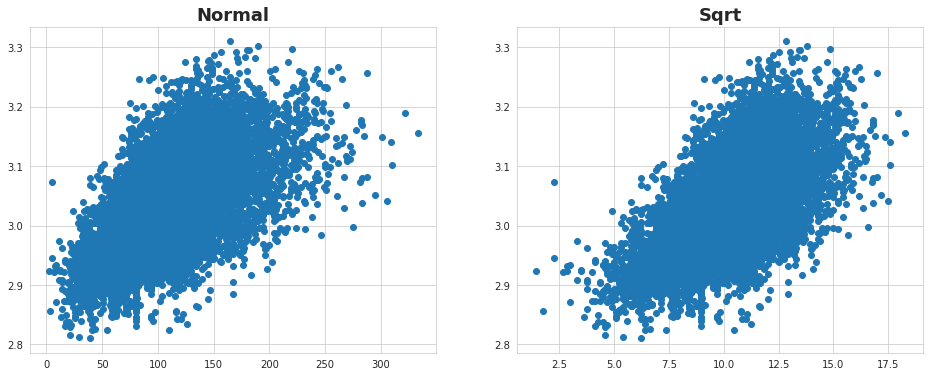

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Normal',size=18,fontweight= 'bold')
plt.plot(df2[columns[i]],df2['Target_log'],'o')
plt.subplot(1,2,2)
plt.title('Sqrt',size=18,fontweight= 'bold')
plt.plot(np.sqrt(df2[columns[i]]),df2['Target_log'],'o')


In [ ]:
df2_5[columns[i]] = np.sqrt(df2_5[columns[i]])

df2_5.index = np.arange(df2_5.shape[0])
X25 = df2_5.drop(columns = ['Target_log','Date'])
Y25 = df2_5['Target_log']
Ypred25,Yv25,vetor_MAPE25 = validation(X25,Y25,Date)


print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Tranformação')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE25),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE25),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE25)/np.sqrt(10),5))

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.21684
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.55241
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46349
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.72595
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52676
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.7453
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23779
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18895
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07929
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.09969


Mape Geral: 4.38365 Std: 1.81328 Erro: 0.57341
Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Tranformação
Mape Geral: 4.38365 Std: 1.81328 Erro: 0.57341


### PT08.S4(NO2)

In [ ]:
i = 5
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.586
SQRT  : 0.582
log   : 0.587
exp   : 0.587


* Não existe uma evolução consideravel de correlação

### PT08.S5(O3)

In [ ]:
i = 6
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.822
SQRT  : 0.823
log   : 0.821
exp   : 0.82


* Não existe um aumento consideravel da correlação

### Temperatura

In [ ]:
i = 7
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.080
SQRT  : nan
log   : 0.080
exp   : 0.08


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Não existe um aumento consideravel da correlação.

### RH

In [ ]:
i = 8
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.089
SQRT  : 0.092
log   : 0.089
exp   : 0.089


* Não existe um aumento consideravel da correlação.

### AH

In [ ]:
i = 9
print('Normal:',np.format_float_positional(np.corrcoef(df2[columns[i]],df2['Target_log'])[0][1],3))
print('SQRT  :',np.format_float_positional(np.corrcoef(np.sqrt(df2[columns[i]]),df2['Target_log'])[0][1],3))
print('log   :',np.format_float_positional(np.corrcoef(10**(df2[columns[i]]/100000),df2['Target_log'])[0][1],3))
print('exp   :',np.format_float_positional(np.corrcoef(np.exp(df2[columns[i]]/10000),df2['Target_log'])[0][1],3))

Normal: 0.151
SQRT  : 0.170
log   : 0.151
exp   : 0.151


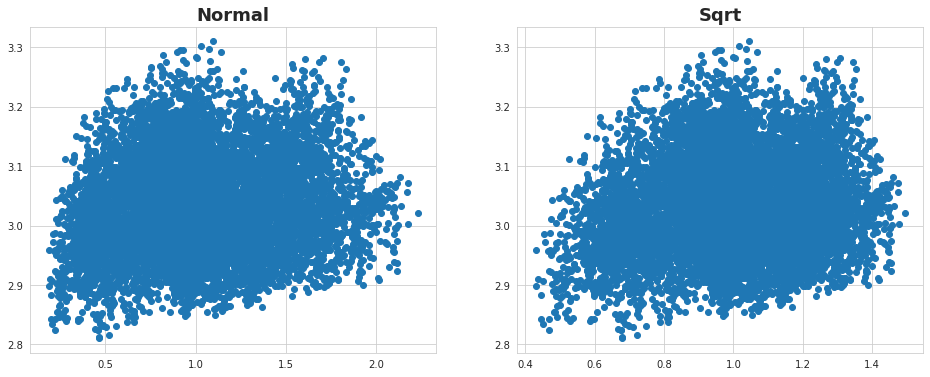

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Normal',size=18,fontweight= 'bold')
plt.plot(df2[columns[i]],df2['Target_log'],'o')
plt.subplot(1,2,2)
plt.title('Sqrt',size=18,fontweight= 'bold')
plt.plot(np.sqrt(df2[columns[i]]),df2['Target_log'],'o')


In [ ]:
df2_9[columns[i]] = np.sqrt(df2_9[columns[i]])

df2_9.index = np.arange(df2_9.shape[0])
X29 = df2_9.drop(columns = ['Target_log','Date'])
Y29 = df2_9['Target_log']
Ypred25,Yv29,vetor_MAPE29 = validation(X29,Y29,Date)


print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Tranformação')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE29),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE29),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE29)/np.sqrt(10),5))

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.21557
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.551
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46370
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.72625
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.5256
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.74491
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23654
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.18712
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07945
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.10045


Mape Geral: 4.38306 Std: 1.81276 Erro: 0.57325
Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Tranformação
Mape Geral: 4.38306 Std: 1.81276 Erro: 0.57325


* Testando todas as tranformações que aumentaram a correlação.

In [ ]:
i = 0
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])
i = 1
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])
i = 2
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])
i = 3
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])
i = 4
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])
i = 8
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])
i = 9
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])

In [ ]:
df2_10[columns[i]] = np.sqrt(df2_10[columns[i]])

df2_10.index = np.arange(df2_10.shape[0])
X210 = df2_10.drop(columns = ['Target_log','Date'])
Y210 = df2_10['Target_log']
Ypred210,Yv210,vetor_MAPE210 = validation(X210,Y210,Date)


print('Bando de dados 2')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE2),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE2),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE2)/np.sqrt(10),5))
print('\n')
print('Tranformação')
print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE210),5),'Std:',
      np.format_float_positional(np.std(vetor_MAPE210),5),
      'Erro:',np.format_float_positional(np.std(vetor_MAPE210)/np.sqrt(10),5))

Data: 2004-04-14 - 2004-05-18 -> MAPE: 8.24874
Data: 2004-05-18 - 2004-06-24 -> MAPE: 7.56769
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.46586
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.72284
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.52838
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.75087
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.23404
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.19014
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.07586
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.09876


Mape Geral: 4.38832 Std: 1.82292 Erro: 0.57646
Bando de dados 2
Mape Geral: 4.38308 Std: 1.81264 Erro: 0.57321


Tranformação
Mape Geral: 4.38832 Std: 1.82292 Erro: 0.57646


# Conclusão.
 
* A melhor configuração apontada é a get_dummies para estações e label_encoder para dias da semana ele obteve um MAPE de 4 %


In [ ]:
df2.to_csv('/content/drive/My Drive/new_dados3.csv')